<a href="https://colab.research.google.com/github/MACHARODRIGO/tRNASec-Study-Project/blob/main/2_align_sequences_prediction_google_colab_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title ### Setup and Dependencies { display-mode: "form" }
# @markdown This cell installs all necessary software and libraries for the notebook, including Infernal, Biopython, ETE3, and others. The code is hidden for a cleaner interface.

# =====================================
# STEP 0: Install dependencies
# =====================================
!apt-get update -qq
!apt-get install -y build-essential wget
# Download Infernal (latest stable version)
!wget http://eddylab.org/infernal/infernal-1.1.5.tar.gz
!tar xzf infernal-1.1.5.tar.gz
%cd infernal-1.1.5

# Configure, compile and install
!./configure --prefix=/usr
!make
!make install

# Return to working dir
%cd /content

# Symlink esl-reformat (and other Easel miniapps) to /usr/bin
!ln -s /content/infernal-1.1.5/easel/miniapps/esl-reformat /usr/bin/esl-reformat
!ln -s /content/infernal-1.1.5/easel/miniapps/esl-alistat /usr/bin/esl-alistat


# Test installation
!esl-reformat -h | head -n 10
!cmalign -h | head -n 10
!apt-get install fasttree
!apt-get install viennarna
!pip install biopython ete3 logomaker cairosvg viennarna pyqt5

import gdown
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO, Phylo
from collections import Counter
import logomaker
import subprocess
import ViennaRNA as RNA
from ete3 import Tree, TreeStyle
from IPython.display import Image, display, Markdown




# CSV (sequence file)
csv_file_id = "1i1syXk3FneuIucDA1zMMXdrMo7LJnLgN"
csv_url = f"https://drive.google.com/uc?id={csv_file_id}"
tRNA_sequence_csv = gdown.download(csv_url, "features.csv", quiet=False)

# Download CM file
!wget http://rfam.xfam.org/family/RF01852/cm -O RF01852.cm

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
--2025-09-02 23:54:36--  http://eddylab.org/infernal/infernal-1.1.5.tar.gz
Resolving eddylab.org (eddylab.org)... 96.126.110.11, 2600:3c03::f03c:91ff:fec8:383c
Connecting to eddylab.org (eddylab.org)|96.126.110.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31300142 (30M) [application/x-gzip]
Saving to: ‘infernal-1.1.5.tar.gz.2’

infernal-1.1.5.tar. 100%[===================>]  29.85M  30.4MB/s    in 1.0s    

2025-09-02 23:54:37 (30.4 MB/s) - ‘infernal-1.1.5.tar.gz.2’ saved [31300142/31300142]

/con

Downloading...
From: https://drive.google.com/uc?id=1i1syXk3FneuIucDA1zMMXdrMo7LJnLgN
To: /content/features.csv
100%|██████████| 92.7k/92.7k [00:00<00:00, 19.2MB/s]


--2025-09-02 23:55:00--  http://rfam.xfam.org/family/RF01852/cm
Resolving rfam.xfam.org (rfam.xfam.org)... 193.62.193.83
Connecting to rfam.xfam.org (rfam.xfam.org)|193.62.193.83|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://rfam.org/family/RF01852/cm [following]
--2025-09-02 23:55:01--  https://rfam.org/family/RF01852/cm
Resolving rfam.org (rfam.org)... 193.62.193.83
Connecting to rfam.org (rfam.org)|193.62.193.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63573 (62K) [text/plain]
Saving to: ‘RF01852.cm’

RF01852.cm          100%[===================>]  62.08K   322KB/s    in 0.2s    

2025-09-02 23:55:01 (322 KB/s) - ‘RF01852.cm’ saved [63573/63573]



In [ ]:
# @title ### Functions { display-mode: "form" }
# @markdown This section contains all the helper functions used throughout the notebook for data processing, alignment, visualization, and analysis.

# =====================================================
# 1. Convert CSV to FASTA
# =====================================================
def convert_csv_to_fasta(csv_path, fasta_path, mapping_file="id_mapping.csv"):
    """
    Convert RNAcentral CSV to FASTA format.
    - Extracts a taxonomic name from description when possible.
    - Cleans species names for FastTree compatibility.
    - Stores a mapping CSV for later reference.
    """
    df = pd.read_csv(csv_path)
    mapping = []

    with open(fasta_path, "w") as fasta_file:
        for _, row in df.iterrows():
            urs_id = str(row['URS_ID']).strip()
            description = str(row['description']).strip()

            match_binomial = re.search(r'([A-Z][a-z]+ [a-z]+)', description)
            species_name = match_binomial.group(1) if match_binomial else description

            safe_species = re.sub(r"[^A-Za-z0-9_.-]", "_", species_name)
            header = f">{urs_id}|{safe_species}|{description}"
            sequence = str(row['Sequence']).strip()
            fasta_file.write(f"{header}\n{sequence}\n")

            mapping.append([urs_id, safe_species, description])

    pd.DataFrame(mapping, columns=["URS_ID", "safe_species", "description"]).to_csv(mapping_file, index=False)
    print(f"✅ FASTA saved: {fasta_path}")
    print(f"✅ Mapping saved: {mapping_file}")

# =====================================================
# 2. Alignment pipeline (Infernal)
# =====================================================

def run_cmalign(fasta_file, sto_file, aligned_file, cm_model="RF01852.cm"):
    """
    Performs multiple sequence alignment using a covariance model.

    This function uses cmalign to align a set of sequences to a pre-trained
    covariance model, then converts the resulting Stockholm format alignment
    into a FASTA file. It also provides a quick preview of the aligned output.

    Parameters
    ----------
    fasta_file : str
        Path to the input FASTA file with unaligned sequences.
    sto_file : str
        Path for the output Stockholm alignment file.
    aligned_file : str
        Path for the output aligned FASTA file.
    cm_model : str
        Path to the covariance model (.cm) file to be used for alignment.
    """
    # 1. Run cmalign directly with !
    print("⏳ Running cmalign...")
    exit_code = os.system(f"cmalign -o {sto_file} {cm_model} {fasta_file}")
    if exit_code != 0:
        print("❌ cmalign failed")
        return
    print(f"✅ Stockholm alignment saved: {sto_file}")

    # 2. Run esl-reformat with !
    print("🔄 Converting to FASTA...")
    os.system(f"esl-reformat afa {sto_file} > {aligned_file}")
    if not os.path.exists(aligned_file):
        print("❌ esl-reformat failed, file not created")
        return
    print(f"✅ Aligned FASTA saved: {aligned_file}")

    # 3. Preview the alignment
    if os.path.exists(aligned_file):
        print("\n📖 Preview of the alignment:")
        with open(aligned_file, "r") as f:
            for line in f.readlines()[:20]: # Displays the first 20 lines
                print(line.strip())
    else:
        print("⚠️ Alignment file not found for preview.")

# =====================================================
# 3. Build Phylogenetic Tree with FastTree
# =====================================================

def build_tree(alignment_file, out_tree="tree.nwk"):
    """Build phylogenetic tree with FastTree in Colab (no subprocess)."""
    import os

    print("🌳 Building phylogenetic tree with FastTree...")
    exit_code = os.system(f"fasttree -nt {alignment_file} > {out_tree}")

    if exit_code != 0 or not os.path.exists(out_tree):
        print("❌ FastTree failed, tree not created")
        return None

    print(f"✅ Tree saved: {out_tree}")
    return out_tree


# =====================================================
# 4.  Tree Visualization
# =====================================================
def visualize_tree(tree_file, out_image="tree_rectangular.png", show=True):
    """Render a rectangular phylogenetic tree with Biopython + matplotlib in Colab."""
    from Bio import Phylo
    import matplotlib.pyplot as plt
    from IPython.display import Image, display

    # Read the tree in Newick format
    tree = Phylo.read(tree_file, "newick")

    # Scale figure height based on the number of leaves
    n_leaves = len(tree.get_terminals())
    height = n_leaves * 0.4   # 0.4 inches per leaf

    fig, ax = plt.subplots(figsize=(25, height))
    Phylo.draw(tree, do_show=False, axes=ax)

    # Adjust labels
    for label in ax.get_yticklabels():
        label.set_rotation(0)
        label.set_fontsize(6)

    ax.margins(y=0.02)

    # Save and close
    plt.savefig(out_image, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"✅ Rectangular tree image saved: {out_image}")

    # Display in Colab if show=True
    if show:
        display(Image(filename=out_image))

# =====================================================
# 5. Tree Interpretation (Markdown report for Notebook)
# =====================================================

def interpret_tree_markdown(tree_file, cutoff=None, min_leaves=10, max_clades=5, output_file=None):
    """
    Interprets a phylogenetic tree and generates a markdown report.

    Parameters
    ----------
    tree_file : str
        Path to the Newick tree file.
    cutoff : float, optional
        Minimum distance from root to consider a clade for reporting (default=None).
    min_leaves : int, optional
        Minimum number of leaves in a clade to be included in the report (default=10).
    max_clades : int, optional
        Maximum number of major clades to report (default=5).
    output_file : str, optional
        Path to a file to save the markdown report (e.g., "report.md").
        If None, the report is displayed in the console/notebook.
    """
    try:
        tree = Phylo.read(tree_file, "newick")
    except FileNotFoundError:
        print(f"Error: The file '{tree_file}' was not found.")
        return
    except Exception as e:
        print(f"Error reading the tree file: {e}")
        return

    leaves = tree.get_terminals()
    n_total = len(leaves)
    report = []
    report.append(f"# 📖 Tree interpretation\n- **Total sequences:** {n_total}")

    # Average branch length
    total_branch_length, num_branches = 0, 0
    for clade in tree.get_nonterminals(order="level"):
        for branch in clade.clades:
            if branch.branch_length is not None:
                total_branch_length += branch.branch_length
                num_branches += 1
    avg_len = total_branch_length / num_branches if num_branches else 0
    report.append(f"- **Average branch length:** {avg_len:.4f}")

    # Tree depth
    try:
        tree_depth = max(tree.distance(tree.root, leaf) for leaf in tree.get_terminals())
    except ValueError:
        tree_depth = 0
    report.append(f"- **Tree depth:** {tree_depth:.4f}")

    # Species composition
    species = [str(leaf).split("|")[1] for leaf in leaves if "|" in str(leaf)]
    sp_counts = Counter(species)
    report.append("## 🧾 Most frequent species")
    report.append("| Rank | Species | # Sequences |")
    report.append("|------|---------|-------------|")
    for i, (sp, c) in enumerate(sp_counts.most_common(10), start=1):
        report.append(f"| {i} | {sp} | {c} |")

    # Optional clade reporting
    if cutoff is not None:
        clade_summaries = []
        for clade in tree.get_nonterminals():
            dist = tree.distance(tree.root, clade)
            if dist >= cutoff:
                desc = clade.get_terminals()
                if len(desc) < min_leaves:  # skip small groups
                    continue
                sp_desc = [str(leaf).split("|")[1] for leaf in desc if "|" in str(leaf)]
                sp_desc_counts = Counter(sp_desc)
                clade_summaries.append({
                    "dist": dist,
                    "n": len(desc),
                    "species": sp_desc_counts.most_common() # ¡CAMBIO CLAVE AQUÍ!
                })

        # Sort by size (largest clades first)
        clade_summaries.sort(key=lambda x: x["n"], reverse=True)

        if clade_summaries:
            report.append(f"\n## 🌳 Major clades (cutoff={cutoff}, min_leaves={min_leaves})")
            for i, cl in enumerate(clade_summaries[:max_clades], start=1):
                # ¡CAMBIO CLAVE AQUÍ! Ahora crea una lista completa
                species_list = [f"{s} ({c})" for s, c in cl["species"]]
                species_str = ", ".join(species_list)

                # Si la lista es muy larga, puedes formatearla de otra manera
                if len(species_list) > 3:
                    species_str = "\n  - " + "\n  - ".join(species_list)
                else:
                    species_str = ", ".join(species_list)

                report.append(
                    f"### Clade {i}\n- distance: {cl['dist']:.3f}\n- leaves: {cl['n']}\n- Species: {species_str}"
                )

    report_text = "\n".join(report)

    if output_file:
        try:
            with open(output_file, "w") as f:
                f.write(report_text)
            print(f"Report successfully saved to '{output_file}'")
        except Exception as e:
            print(f"Error saving file: {e}")
    else:
        display(Markdown(report_text))


# =====================================================
# 6. Generate Sequence Logo
# =====================================================

def generate_sequence_logo(alignment_file, out_logo="logo.png"):

    """
    Generate a sequence logo from a multiple alignment.

    Parameters
    ----------
    alignment_fasta : str
        Path to the aligned FASTA file.
    out_logo : str
        Output path for the PNG logo.
    gap_threshold : float
        Discards alignment columns with more than this fraction of gaps (default = 0.9).
    scale_factor : float
        Controls figure width scaling (default = 0.35, increase if letters look cramped).
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import logomaker
    from Bio import SeqIO
    from IPython.display import Image

    seqs = [str(rec.seq) for rec in SeqIO.parse(alignment_file, "fasta")]
    df = pd.DataFrame([list(seq) for seq in seqs])
    gap_fraction = (df == "-").sum() / len(df)
    df = df.loc[:, gap_fraction < 0.9].replace("-", pd.NA)

    freq_matrix = pd.DataFrame({i: df[i].value_counts(normalize=True) for i in df.columns}).fillna(0).T
    fig, ax = plt.subplots(figsize=(max(12, freq_matrix.shape[0]*0.35), 6))
    logomaker.Logo(freq_matrix, ax=ax, color_scheme="classic")
    plt.savefig(out_logo, dpi=300, bbox_inches="tight", transparent=True)
    display(Image(filename=out_logo))

# =====================================================
# 7. RNA Secondary Structures by Species (ViennaRNA)
# =====================================================

def plot_rna_by_species(
    fasta_file,
    out_dir="rna_plots_by_species",
    max_per_fig=12,
    total_figures=None   # 👈 hard global limit
):
    """
    Generate RNA secondary structure plots grouped by species using ViennaRNA.

    Parameters
    ----------
    fasta_file : str
        Input FASTA file.
    out_dir : str
        Directory to save figures.
    max_per_fig : int
        Max sequences per figure (default=12).
    total_figures : int or None
        If set, stop after generating this many figures across ALL species.
        If None, generate all.
    """
    import os, re
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from Bio import SeqIO
    import ViennaRNA as RNA
    from IPython.display import display, Image

    os.makedirs(out_dir, exist_ok=True)

    sequences = list(SeqIO.parse(fasta_file, "fasta"))
    species_groups = {}

    # --- Group sequences by species ---
    for record in sequences:
        parts = record.id.split('|')
        description = " ".join(parts[1:]) if len(parts) > 1 else record.id
        match_binomial = re.search(r"([A-Z][a-z]+ [a-z]+)", description)
        species_name = match_binomial.group(1) if match_binomial else (parts[1] if len(parts) > 1 else record.id)
        safe_species = species_name.replace(" ", "_")
        species_groups.setdefault(safe_species, {"name": species_name, "records": []})
        species_groups[safe_species]["records"].append(record)

    print(f"📥 {len(sequences)} sequences loaded, grouped into {len(species_groups)} species.")

    global_count = 0

    for species_id, info in species_groups.items():
        species_name = info["name"]
        group = info["records"]
        print(f"\n🔬 Species: {species_name} ({len(group)} sequences)")

        for i in range(0, len(group), max_per_fig):
            if total_figures is not None and global_count >= total_figures:
                print(f"⏹️ Limit of {total_figures} figures reached. Stopping.")
                return

            block = group[i:i+max_per_fig]
            fig, axes = plt.subplots(3, 4, figsize=(18, 14))
            axes = axes.flatten()

            for j, record in enumerate(block):
                seq = str(record.seq).replace("T","U")
                if not seq:
                    continue

                ss, mfe = RNA.fold(seq)
                safe_id = record.id.replace('|','_').replace(" ","_")
                svg_file = os.path.join(out_dir, f"{safe_id}.svg")
                RNA.svg_rna_plot(seq, ss, svg_file)

                png_file = svg_file.replace(".svg",".png")
                try:
                    import cairosvg
                    cairosvg.svg2png(url=svg_file, write_to=png_file)
                except ImportError:
                    png_file = None

                urs_id = record.id.split('|')[0]
                ax = axes[j]
                if png_file and os.path.exists(png_file):
                    img = mpimg.imread(png_file)
                    ax.imshow(img)
                ax.set_title(f"{urs_id}\nMFE={mfe:.2f}", fontsize=9)
                ax.axis("off")

            # hide empty slots
            for k in range(len(block), len(axes)):
                axes[k].axis("off")

            fig.suptitle(f"RNA structures — {species_name}", fontsize=16)
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])

            output_fig = os.path.join(out_dir, f"rna_structures_{species_id}_{i//max_per_fig+1}.png")
            fig.savefig(output_fig, dpi=300)
            plt.close(fig)

            print(f"✅ Figure saved: {output_fig}")

            if global_count == 0:
                display(Image(filename=output_fig))

            global_count += 1


## 📥 Step 1: Convert CSV to FASTA
We start by transforming the RNAcentral dataset (CSV) into a FASTA file,
with clean species names and a mapping file for later interpretation.

In [ ]:
tRNA_sequences_fasta = "tRNA_sequences.fasta"
convert_csv_to_fasta(tRNA_sequence_csv, tRNA_sequences_fasta)

NameError: name 'tRNA_sequence_csv' is not defined

  ## 🔗 Step 2: Run alignment with Infernal
We use `cmalign` and `esl-reformat` to align all sequences against the RF01852 model.


In [ ]:
# A. Ejecutar el alineador
run_cmalign(fasta_file="tRNA_sequences.fasta", sto_file="tRNA_sequences.sto", aligned_file="tRNA_aligned.fasta", cm_model="RF01852.cm")

⏳ Running cmalign...
✅ Stockholm alignment saved: tRNA_sequences.sto
🔄 Converting to FASTA...
✅ Aligned FASTA saved: tRNA_aligned.fasta

📖 Preview of the alignment:
>URS00001DA281_9606|Homo_sapiens|Homo sapiens (human) tRNA-SeC (anticodon TCA) 1-1 (TRU-TCA1-1)
......GCCCGGAUG.....AUCC.U.C.A.GUGGU........................
.....CUGGGGUGCAGGCUUCAA.A..............................CCUG.
U.A.GCUGUCUAGC--......--...........GACAGA..-G.UGG.UUCAAUU...
.........................CCAC............CUUU.CGG...G.Cg....
.......
>URS0000C8E9EB_9606|Homo_sapiens|Homo sapiens (human) tRNA-SeC (anticodon TCA) 2-1 (TRU-TCA2-1)
......GCUCGGAUG.....AUCC.U.C.A.GUGGU........................
.....CUGGGGUGCAGGCUUCAA.A..............................CCUG.
U.A.GCUGUCUAGU--......--...........GACAGA..-G.UGG.UUCAAUU...
.........................CCAC............CUUU.GUA...-.-.....
.......
>URS00008FED48_9606|Homo_sapiens|selenocysteine tRNA from Homo sapiens (PDB 4RQF, chain C)
......GGCCGGAUG.....AUCC.U.C.A.GUGGU............

## 🌳 Step 3: Build phylogenetic tree
Aligned sequences are passed to FastTree to infer a phylogenetic tree.

In [ ]:
tree_file = build_tree("tRNA_aligned.fasta")

🌳 Building phylogenetic tree with FastTree...
✅ Tree saved: tree.nwk


## 🌐 Step 4: Radial visualization
Render the tree in a circular layout using matplotlib

In [ ]:
visualize_tree(tree_file)

✅ Rectangular tree image saved: tree_rectangular.png


## 📖 Step 5: Automatic interpretation
Generate a Markdown report with major clades and species distribution.

In [ ]:
# Summary + top 10 clades bigger than 15 leaves at distance ≥1.2
interpret_tree_markdown("tree.nwk", cutoff=1, min_leaves=20, max_clades=6) #output_file='report.md' if you want to store it

Report successfully saved to 'report.md'


## 🧬 Step 6: Sequence logo
Create a sequence logo from the aligned FASTA to visualize base conservation.

/usr/local/lib/python3.12/dist-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character '.' is not in color_dict. Using black.
  warnings.warn(str(Error))
/usr/local/lib/python3.12/dist-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'N' is not in color_dict. Using black.
  warnings.warn(str(Error))


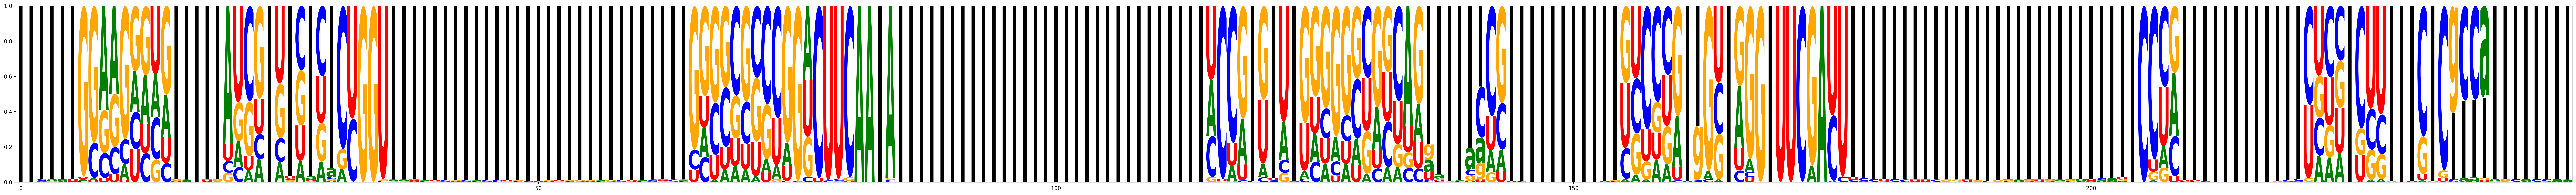

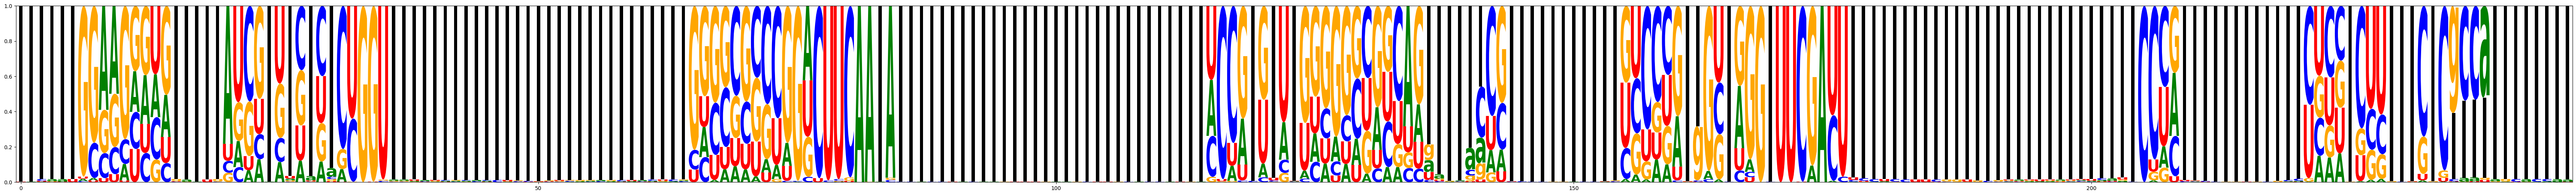

In [ ]:
generate_sequence_logo("tRNA_aligned.fasta") #see the file logo.png

## 🌀 Step 7: RNA secondary structure plots
Predict secondary structures for each species using ViennaRNA.

📥 400 sequences loaded, grouped into 252 species.

🔬 Species: Homo_sapiens (7 sequences)
✅ Figure saved: rna_plots_by_species/rna_structures_Homo_sapiens_1.png


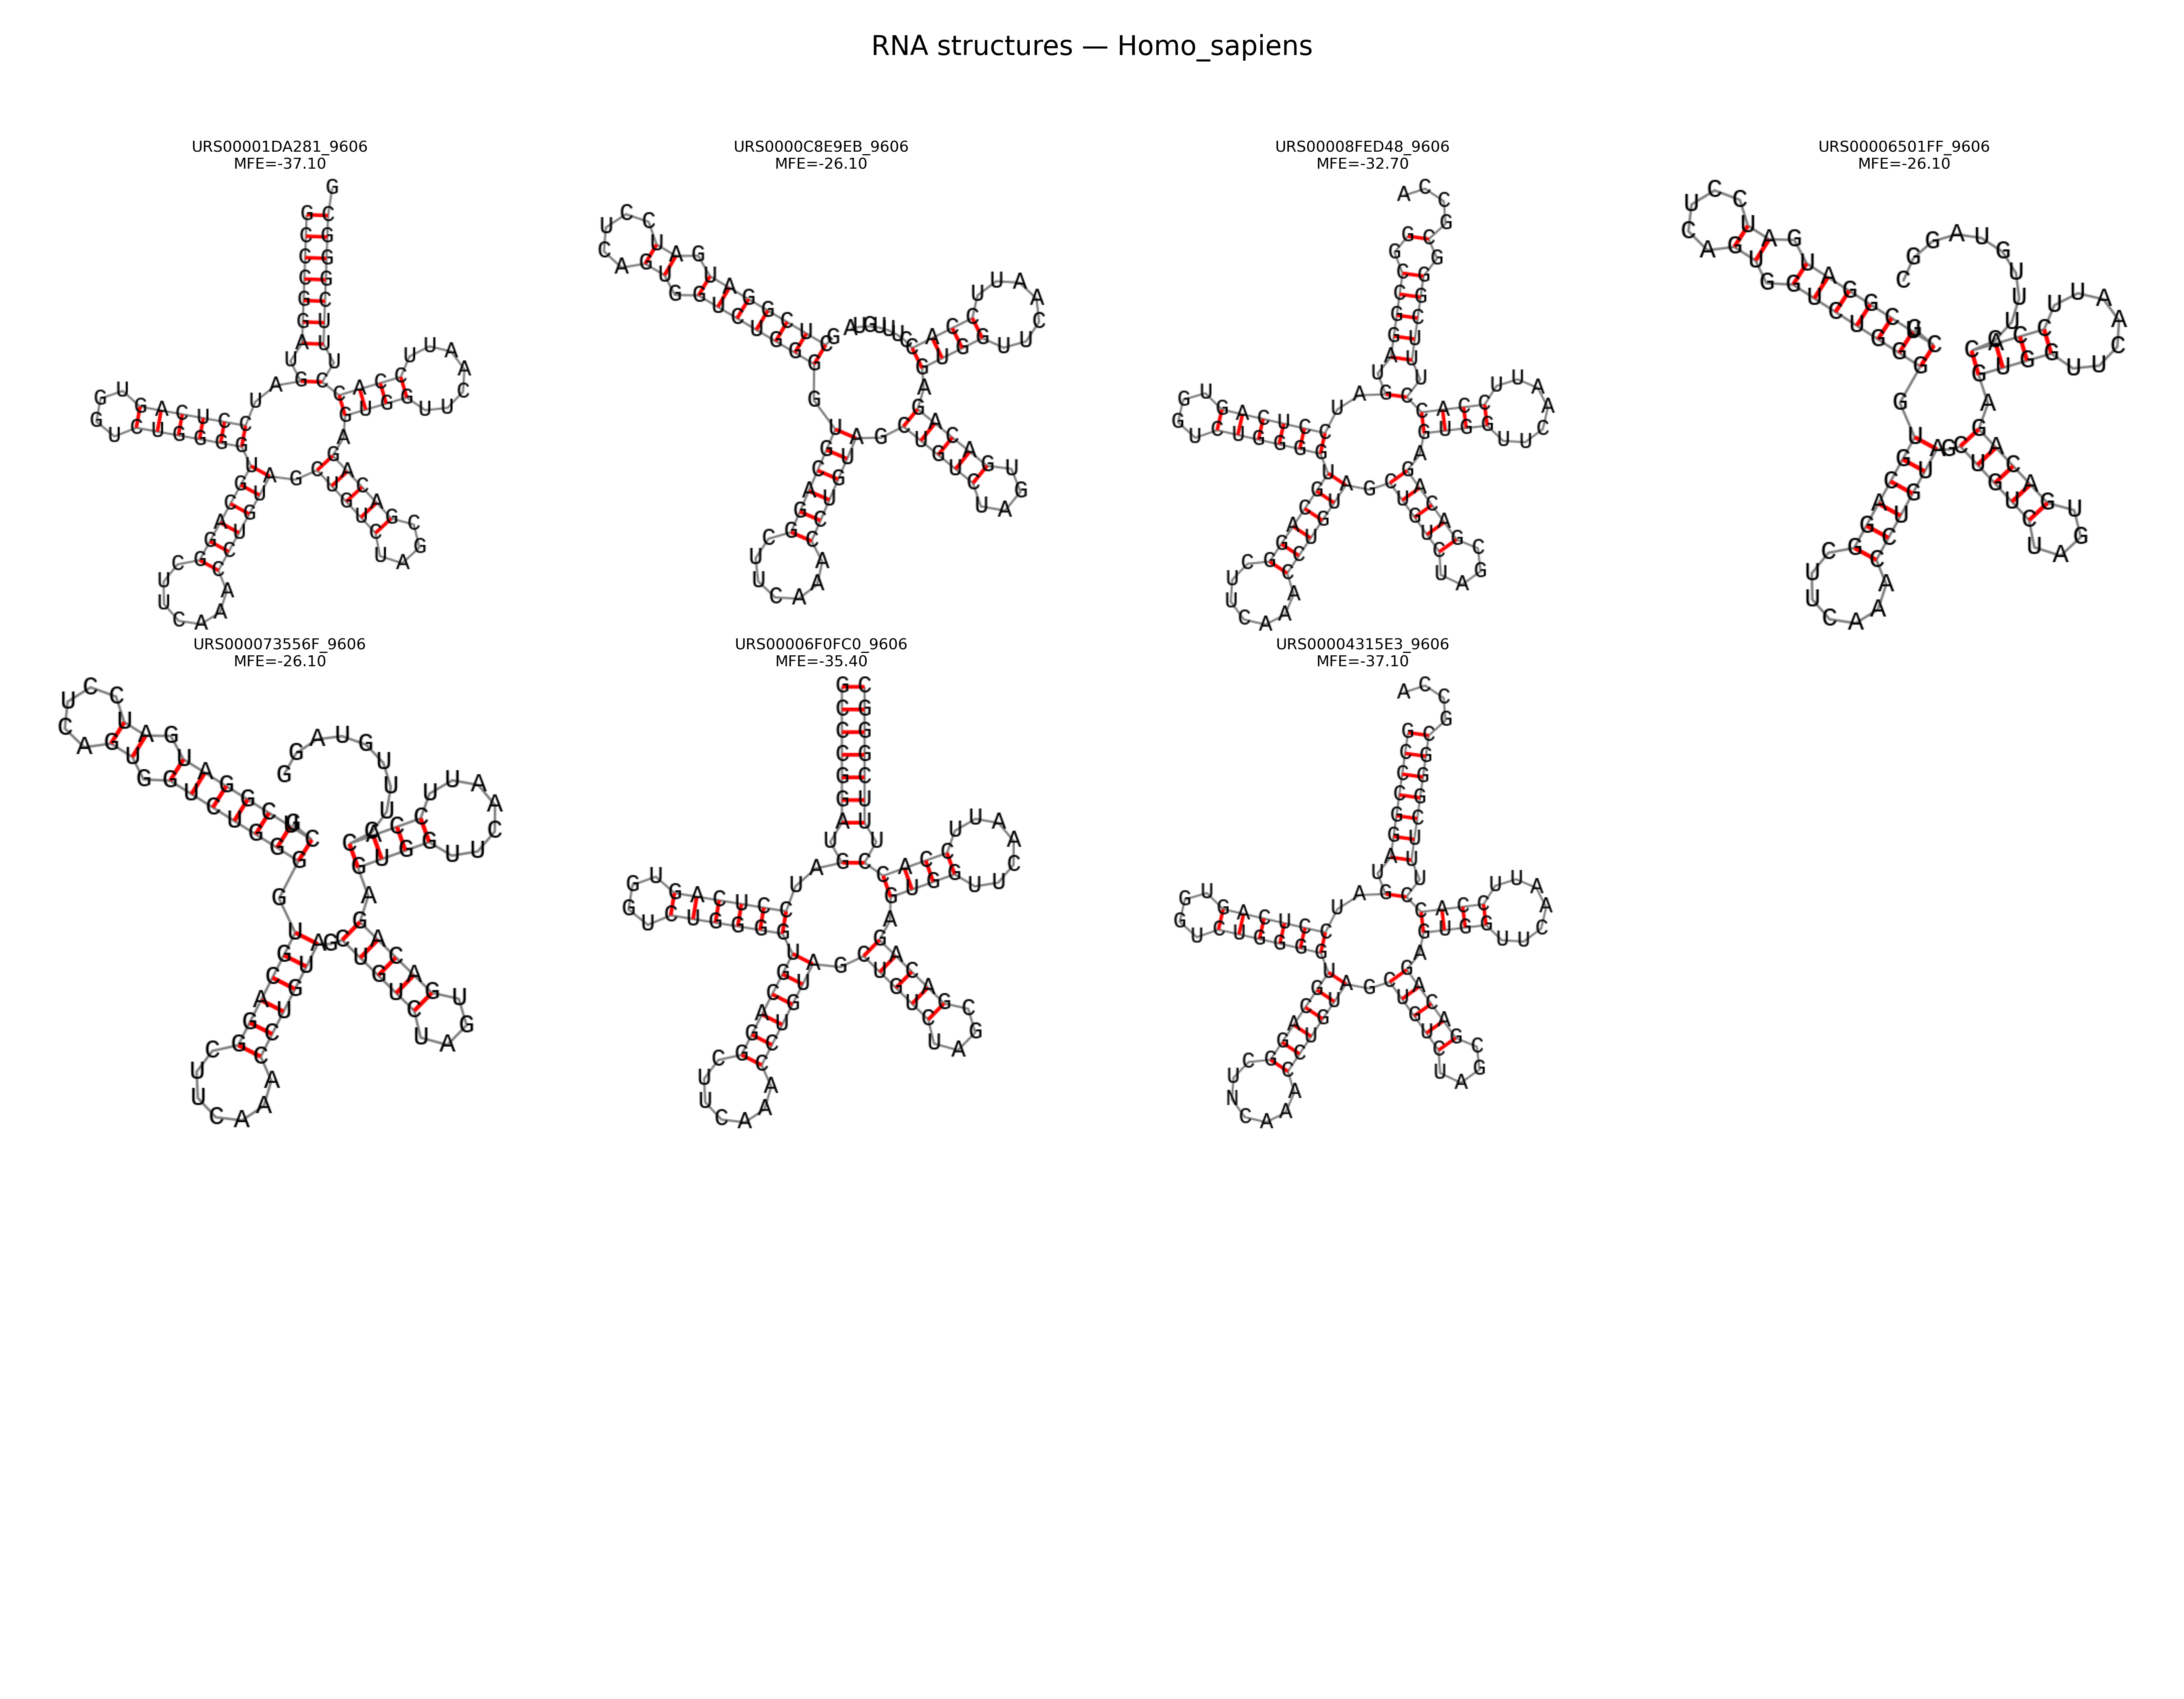


🔬 Species: Sec_from (1 sequences)
✅ Figure saved: rna_plots_by_species/rna_structures_Sec_from_1.png

🔬 Species: Mus_musculus (3 sequences)
✅ Figure saved: rna_plots_by_species/rna_structures_Mus_musculus_1.png

🔬 Species: Caenorhabditis_elegans (2 sequences)
✅ Figure saved: rna_plots_by_species/rna_structures_Caenorhabditis_elegans_1.png

🔬 Species: Drosophila_melanogaster (4 sequences)
✅ Figure saved: rna_plots_by_species/rna_structures_Drosophila_melanogaster_1.png

🔬 Species: Danio_rerio (4 sequences)
⏹️ Limit of 5 figures reached. Stopping.


In [ ]:
plot_rna_by_species("tRNA_sequences.fasta", total_figures=5)


## 📖 Final Interpretation of the tRNASec Analysis

### 1. General composition and diversity
The dataset included **400 tRNASec sequences** from a wide variety of organisms:  
bacteria, protozoa, metazoans, and vertebrates.  

- **Most frequent taxa:**
  - *Sheep gut metagenome* (27 sequences, likely representing ruminal bacteria).  
  - *Proteus sp.*, *Pseudomonas sp.*, *Burkholderia sp.* (bacterial genera).  
  - Model organisms: *Homo sapiens* (7), *Mus musculus* (3),  
    *Danio rerio* (3), and *Drosophila melanogaster* (3).  

This diversity reflects the broad distribution of the selenoprotein machinery across kingdoms.  

---

### 2. Phylogenetic tree
The **phylogenetic tree** (FastTree) showed:  
- Tree depth: **3.05**  
- Average branch length: **0.043**  

**Six major clades** were identified (≥20 leaves, distance ≥1):  

- **Clades 1 and 2**: dominated by *Homo sapiens*, *Mus musculus*, *Danio rerio*,  
  and arthropods such as *Ixodes* and *Drosophila*.  
  → Reflects conservation of tRNASec in metazoans, with lineage-specific subdivisions.  

- **Clades 3–5**: grouping *Plasmodium spp.* and other apicomplexans (*Toxoplasma*).  
  → Suggests specialization of tRNASec in parasitic contexts.  

- **Clade 6**: insects and mites.  
  → Indicates diversification within Ecdysozoa.  

🔎 **Interpretation:** although the function of tRNASec (selenocysteine insertion) is conserved,  
the sequence and structure exhibit lineage-specific adaptations.  

---

### 3. Sequence logos
The sequence logo revealed **4–5 conserved blocks**, separated by variable regions:  

- **Block 1 (left):** conserved triplets such as **C-G-G**.  
- **Block 2:** conserved triplet **U-C-C**.  
- **Block 3:** dominated by **G and C** (motifs **G-G-C / C-G-G**).  
- **Block 4:** mixed, with some highly conserved positions.  
- **Block 5 (right):** clearly conserved triplets such as **C-U-U** and **U-G-A**.  

✅ **Summary:**  
- At least **4–5 conserved regions** are visible.  
- Conserved triplets are often dominated by **G and C**.  
- Variable stretches in between likely correspond to loops or less constrained regions.  

---

### 4. Secondary structures
Predicted RNA structures show clear **species-specific patterns**:  

- **Homo sapiens:** canonical elongated tRNASec structures,  
  with extended acceptor stem, MFE between -26 and -37 kcal/mol.  
- **Caenorhabditis elegans:** more linear, less compact architectures.  
- **Drosophila melanogaster:** similar to mammals, but with variable loop size  
  and intermediate stability (-27 to -35 kcal/mol).  

👉 **Interpretation:**  
- The **extended acceptor stem** remains a hallmark of tRNASec.  
- Structural variation across groups suggests differences in interaction  
  with lineage-specific translation factors.  

---

### 5. Integrative conclusion
The analysis confirms that **tRNASec is universal yet evolutionarily diverse**:  

- **Strict conservation** in essential regions (triplets dominated by G/C and motifs like **UGA**).  
- **Distinct evolutionary separation** of metazoans, protists, and bacteria,  
  consistent with phylogeny and secondary structures.  
- Each lineage seems to **optimize tRNASec** according to its translational context  
  (e.g., type/number of selenoproteins, SECIS interaction, selenium availability).  

---

✅ **Overall, the pipeline successfully integrated:**  
- phylogenetic tree  
- conserved sequence motifs  
- secondary structures  

providing a coherent view of the **functional unity and evolutionary diversity** of tRNASec.
